In [1]:
# 宮脇さんコメント


import os
import numpy as np 
import pandas as pd 
import japanize_matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import sweetviz as sv
import mlflow
import mlflow.sklearn

from sklearn.model_selection import train_test_split
from contextlib import contextmanager
from sklearn.preprocessing import LabelEncoder
from time import time
from feature_engine.encoding import OrdinalEncoder

class Timer:
    def __init__(self, logger=None, format_str="{:.3f}[s]", prefix=None, suffix=None, sep=" "):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)
%matplotlib inline

In [2]:
mlflow.set_tracking_uri("https://github.com/Kenji221/kaggle_01.git")

In [3]:
train_df = pd.read_csv("../data/train_utf.csv")
test_df = pd.read_csv("../data/test_utf.csv")

In [4]:
# 加工前EDA
my_report = sv.compare([train_df, "Train"], [test_df, "Test"], "賃料")
#直接ブラウザに表示
my_report.show_html("sweetviz/sweetviz_report_2col.html")

Feature: 種類                                  |█▉        | [ 19%]   00:00 -> (00:04 left)  /opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 36035 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 36024 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 12381 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 12398 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 20182 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-p

Report sweetviz/sweetviz_report_2col.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [5]:
def merge_by_id(left_df, right_df):
    return pd.merge(left_df["ID"], right_df, on="ID", how="left").drop(columns=["ID"])

In [6]:
def create_rent_feature_train(input_df: pd.DataFrame):
    """input_dfは train or test.csv のデータが入ってくることを想定しています."""

    use_columns = [
        "共益費",
        "敷金/礼金",
        "保証金",
        "専有面積(m2)"
    ]

    return merge_by_id(input_df, train_df)[use_columns]

In [7]:
def create_rent_feature_test(input_df: pd.DataFrame):
    """input_dfは train or test.csv のデータが入ってくることを想定しています."""

    use_columns = [
        "共益費",
        "敷金/礼金",
        "保証金",
        "専有面積(m2)"
    ]

    return merge_by_id(input_df, test_df)[use_columns]

In [8]:
create_rent_feature_train(train_df)

,共益費,敷金/礼金,保証金,専有面積(m2)
0,0,1.0,0.000000,18.23
1,0,0.0,0.000000,18.98
2,10000,1.0,1.000000,30.09
3,2000,1.0,1.000000,22.96
4,0,0.0,2.127660,72.06
...,...,...,...,...
65613,6820,0.0,1.288245,21.66
65614,11000,3.0,1.000000,59.76
65615,3000,1.0,1.000000,46.35
65616,7000,0.0,0.000000,24.85


In [9]:
create_rent_feature_test(test_df)

,共益費,敷金/礼金,保証金,専有面積(m2)
0,5000,0.0,1.0,49.21
1,8000,1.0,0.0,25.10
2,4000,1.0,1.0,18.00
3,0,1.0,0.0,37.00
4,7000,0.0,1.0,43.98
...,...,...,...,...
43744,3000,1.0,1.0,25.00
43745,0,1.0,0.0,34.00
43746,0,1.0,1.0,21.56
43747,7000,1.0,1.0,27.58


In [10]:
def one_hot_encoding_type(input_df):
    val = "種類"
    out_df = pd.DataFrame()
    target_colname = val
    target_series = input_df[target_colname]
    unique_values = target_series.unique()

    for value in unique_values:
        is_value = target_series == value
        out_df[value] = is_value.astype(int)
    if len (out_df) == len(input_df):
        return out_df
    else:
        return print("something went wrong")

In [11]:
one_hot_encoding_type(train_df)

,賃貸アパート,賃貸マンション,賃貸一戸建て,賃貸テラス・タウンハウス,賃貸その他
0,1,0,0,0,0
1,0,1,0,0,0
2,0,1,0,0,0
3,1,0,0,0,0
4,0,0,1,0,0
...,...,...,...,...,...
65613,0,1,0,0,0
65614,0,1,0,0,0
65615,1,0,0,0,0
65616,0,1,0,0,0


In [12]:
one_hot_encoding_type(test_df)

,賃貸アパート,賃貸マンション,賃貸テラス・タウンハウス,賃貸一戸建て,賃貸その他
0,1,0,0,0,0
1,0,1,0,0,0
2,0,1,0,0,0
3,0,1,0,0,0
4,0,1,0,0,0
...,...,...,...,...,...
43744,0,1,0,0,0
43745,0,1,0,0,0
43746,0,1,0,0,0
43747,0,1,0,0,0


In [13]:
def impute(var01):
    walk = var01[0]
    if pd.isnull(walk):
        return 10
    else:
        return walk


In [14]:
# 階数と年齢を別々にする
def change_floor_year(input_df):
    floor = "階数"
    year = "築年数"
    target_series = input_df[[floor,year]]
    target_series[floor] = target_series[floor].replace("平屋","1階建")
    target_series[floor] = target_series[floor].str.extract(r'(\d+)階建').astype(int)
    target_series[year] = target_series[year].replace("新築","築1年")
    target_series[year] = target_series[year].str.extract(r'(\d+)年').astype(int)

    return target_series



In [15]:
change_floor_year(test_df)

<ipython-input-14-112749881604>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_series[floor] = target_series[floor].replace("平屋","1階建")
<ipython-input-14-112749881604>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_series[floor] = target_series[floor].str.extract(r'(\d+)階建').astype(int)
<ipython-input-14-112749881604>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

,階数,築年数
0,3,10
1,11,3
2,3,40
3,4,55
4,5,16
...,...,...
43744,8,21
43745,5,45
43746,13,19
43747,7,24


In [16]:
train_df_02=pd.DataFrame()
train_df_02[["最寄り駅","徒歩"]] =train_df["最寄り駅1"].str.extract(r'([^/]+) 歩(\d+)分')
train_df_02["間取り"]=train_df["間取り"]
test_df_02=pd.DataFrame()
test_df_02[["最寄り駅","徒歩"]] =test_df["最寄り駅1"].str.extract(r'([^/]+) 歩(\d+)分')
test_df_02["間取り"]=test_df["間取り"]


In [17]:
print(train_df_02.nunique(),test_df_02.nunique())

最寄り駅    1357
徒歩        66
間取り       39
dtype: int64 最寄り駅    1206
徒歩        61
間取り       37
dtype: int64


In [18]:
test_df_02.nunique()

最寄り駅    1206
徒歩        61
間取り       37
dtype: int64

In [19]:
def label_encode_categorical_columns(train_df, test_df, column_names):
    # Combine train and test data
    combined_data = pd.concat([train_df, test_df])

    # Apply label encoding to specified columns
    for column_name in column_names:
        le = LabelEncoder()
        combined_data[column_name] = le.fit_transform(combined_data[column_name])

    # Split combined data back into train and test data
    train_encoded = combined_data.iloc[:len(train_df)]
    test_encoded = combined_data.iloc[len(train_df):]

    return train_encoded, test_encoded

In [20]:
test_df_02

,最寄り駅,徒歩,間取り
0,本陣駅,3,1LDK
1,西荻窪駅,3,1DK
2,曙橋駅,4,ワンルーム
3,富士見ヶ丘駅,1,1LDK
4,旭ヶ丘駅,3,1LDK
...,...,...,...
43744,西馬込駅,3,1K
43745,蒲田駅,20,1LDK
43746,大井町駅,5,1K
43747,用賀駅,4,1K


In [21]:
train_df_02

,最寄り駅,徒歩,間取り
0,西荻窪駅,12,1K
1,大阪港駅,4,1K
2,中野坂上駅,3,2K
3,駒込駅,9,1K
4,粉浜駅,3,2LDK
...,...,...,...
65613,堺筋本町駅,4,1K
65614,北四番丁駅,5,2DK
65615,奥沢駅,8,1LDK
65616,神宮前駅,10,1K


In [22]:
def impute(var01):
    walk = var01[0]
    if pd.isnull(walk):
        return 10
    else:
        return walk


In [23]:
train_df_02["徒歩"] = train_df_02[["徒歩"]].apply(impute,axis=1)
train_df_02["徒歩"] = train_df_02["徒歩"].astype(int)

In [24]:
test_df_02["徒歩"] = test_df_02[["徒歩"]].apply(impute,axis=1)
test_df_02["徒歩"] = test_df_02["徒歩"].astype(int)

In [25]:
def one_hot_encoding(input_df,val):
    out_df = pd.DataFrame()
    target_colname = val
    target_series = input_df[target_colname]
    unique_values = target_series.unique()

    for value in unique_values:
        is_value = target_series == value
        out_df[value] = is_value.astype(int)
    return out_df


In [26]:
def create_country(input_df):
    out_df = pd.DataFrame()
    country = "都道府県"
    state = "区"
    address = "住所"
    out_df[[country,state]] =input_df[address].str.split('都|県|道|府|市|区', expand=True).iloc[:, [0, -1]]
  #　TODO見直し
    out_df.drop("区",axis=1,inplace = True)
    return one_hot_encoding(out_df,"都道府県")

In [27]:
create_country(train_df)

,東京,大阪,愛知,宮城,北海
0,1,0,0,0,0
1,0,1,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,0,1,0,0,0
...,...,...,...,...,...
65613,0,1,0,0,0
65614,0,0,0,1,0
65615,1,0,0,0,0
65616,0,0,1,0,0


In [28]:
def create_state(input_df):
    out_df = pd.DataFrame()
    country = "都道府県"
    state = "区"
    address = "住所"

    out_df[[country]]=input_df[address].str.extract(r'(.+?[都道府県])')
    out_df[[state]]=input_df[address].str.extract(r'([^都道府県]+?[市町村区])')
    # out_df[[state]]=input_df.apply(lambda row: row['都道府県'] if pd.isna(row['区']) else row['区'], axis=1)
    return out_df[state]

In [29]:
train_df_02["区"] = create_state(train_df)

In [30]:
test_df_02["区"] = create_state(test_df)

In [31]:
train_df_02, test_df_02 = label_encode_categorical_columns(train_df_02, test_df_02, ["最寄り駅","間取り","区"])

In [32]:
train_df_02

,最寄り駅,徒歩,間取り,区
0,1350,12,2,15
1,533,4,2,11
2,124,3,11,2
3,1519,9,2,4
4,1208,3,12,11
...,...,...,...,...
65613,473,4,2,11
65614,301,5,10,3
65615,552,8,3,0
65616,1170,10,2,7


In [33]:
test_df_02

,最寄り駅,徒歩,間取り,区
0,867,3,3,7
1,1350,3,1,15
2,841,4,41,13
3,577,1,3,15
4,815,3,3,3
...,...,...,...,...
43744,1353,3,2,10
43745,1292,20,3,10
43746,481,5,2,8
43747,1132,4,2,0


In [34]:
def create_feature_train(input_df):

    # functions に特徴量作成関数を配列で定義しました.
    # どの関数も同じ input / output のインターフェイスなので for で回せて嬉しいですね ;)
    functions = [
        create_rent_feature_train,
        one_hot_encoding_type,
        change_floor_year,
        create_country
    ]

    out_df = pd.DataFrame()
    for func in functions:
        func_name = str(func.__name__)
        with Timer(prefix=f"create {func_name}"):
            _df = func(input_df)
        out_df = pd.concat([out_df, _df], axis=1)

    return out_df

In [35]:
def create_feature_test(input_df):

    # functions に特徴量作成関数を配列で定義しました.
    # どの関数も同じ input / output のインターフェイスなので for で回せて嬉しいですね ;)
    functions = [
        create_rent_feature_test,
        one_hot_encoding_type,
        change_floor_year,
        create_country
    ]

    out_df = pd.DataFrame()
    for func in functions:
        func_name = str(func.__name__)
        with Timer(prefix=f"create {func_name}"):
            _df = func(input_df)
        out_df = pd.concat([out_df, _df], axis=1)

    return out_df

In [36]:
with Timer(prefix="train..."):
    train_feat_df = create_feature_train(train_df)

with Timer(prefix="test..."):
    test_feat_df = create_feature_test(test_df)

X = train_feat_df
y = train_df["賃料"].values

create create_rent_feature_train 0.052[s]
create one_hot_encoding_type 0.025[s]


<ipython-input-14-112749881604>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_series[floor] = target_series[floor].replace("平屋","1階建")
<ipython-input-14-112749881604>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_series[floor] = target_series[floor].str.extract(r'(\d+)階建').astype(int)
<ipython-input-14-112749881604>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

create change_floor_year 0.247[s]
create create_country 0.148[s]
train... 0.482[s]
create create_rent_feature_test 0.027[s]
create one_hot_encoding_type 0.015[s]
create change_floor_year 0.077[s]
create create_country 0.191[s]
test... 0.315[s]


In [37]:
X = X.join(train_df_02,how ="left")

In [38]:
train_feat_df = train_feat_df.join(train_df_02, how = "left")

In [39]:
# X = X.values
X.dtypes

共益費               int64
敷金/礼金           float64
保証金             float64
専有面積(m2)        float64
賃貸アパート            int64
賃貸マンション           int64
賃貸一戸建て            int64
賃貸テラス・タウンハウス      int64
賃貸その他             int64
階数                int64
築年数               int64
東京                int64
大阪                int64
愛知                int64
宮城                int64
北海                int64
最寄り駅              int64
徒歩                int64
間取り               int64
区                 int64
dtype: object

In [40]:
test_feat_df.dtypes

共益費               int64
敷金/礼金           float64
保証金             float64
専有面積(m2)        float64
賃貸アパート            int64
賃貸マンション           int64
賃貸テラス・タウンハウス      int64
賃貸一戸建て            int64
賃貸その他             int64
階数                int64
築年数               int64
愛知                int64
東京                int64
宮城                int64
大阪                int64
北海                int64
dtype: object

In [41]:
test_feat_df = test_feat_df.join(test_df_02, how = "left")

In [42]:
list01 = list(X.columns)

In [43]:
test_feat_df = test_feat_df.reindex(columns =list01)

In [44]:
test_feat_df

,共益費,敷金/礼金,保証金,専有面積(m2),賃貸アパート,賃貸マンション,賃貸一戸建て,賃貸テラス・タウンハウス,賃貸その他,階数,築年数,東京,大阪,愛知,宮城,北海,最寄り駅,徒歩,間取り,区
0,5000,0.0,1.0,49.21,1,0,0,0,0,3,10,0,0,1,0,0,867,3,3,7
1,8000,1.0,0.0,25.10,0,1,0,0,0,11,3,1,0,0,0,0,1350,3,1,15
2,4000,1.0,1.0,18.00,0,1,0,0,0,3,40,1,0,0,0,0,841,4,41,13
3,0,1.0,0.0,37.00,0,1,0,0,0,4,55,1,0,0,0,0,577,1,3,15
4,7000,0.0,1.0,43.98,0,1,0,0,0,5,16,0,0,0,1,0,815,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43744,3000,1.0,1.0,25.00,0,1,0,0,0,8,21,1,0,0,0,0,1353,3,2,10
43745,0,1.0,0.0,34.00,0,1,0,0,0,5,45,1,0,0,0,0,1292,20,3,10
43746,0,1.0,1.0,21.56,0,1,0,0,0,13,19,1,0,0,0,0,481,5,2,8
43747,7000,1.0,1.0,27.58,0,1,0,0,0,7,24,1,0,0,0,0,1132,4,2,0


In [45]:
# 加工前EDA
my_report = sv.compare([X, "Train"], [test_feat_df, "Test"])
#直接ブラウザに表示
my_report.show_html("sweetviz/sweetviz_report_3col.html")

[Step 3/3] Generating associations graph     |          | [  0%]   00:00 -> (? left)           /opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 20849 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 30410 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 36027 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 25975 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 37329 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/s

Report sweetviz/sweetviz_report_3col.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [46]:
mlflow.start_run()
mlflow.log_param("listname",list01)
mlflow.end_run()

MlflowException: API request to endpoint /api/2.0/mlflow/runs/create failed with error code 403 != 200. Response body: 'Cookies must be enabled to use GitHub.'

In [ ]:
dsd

In [ ]:
X = X.values

In [ ]:
from sklearn.model_selection import StratifiedKFold

fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=510)
cv = fold.split(X, y)
cv = list(cv) # split の返り値は generator なので list 化して何度も iterate できるようにしておく

c:\users\kaminogo.kenji\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [ ]:
# from sklearn.model_selection import KFold
# fold = KFold(n_splits=10, shuffle=True, random_state=71)
# cv = list(fold.split(X, y))
# # もともとが generator なため明示的に list に変換する
# # oof, models = fit_lgbm(X, y, cv, params=params, verbose=500)


In [ ]:
from sklearn.metrics import mean_squared_error

def root_mean_squared_error(y_true, y_pred):
    """mean_squared_error の root (0.5乗)"""
    return mean_squared_error(y_true, y_pred) ** .5

In [ ]:
import lightgbm as lgbm

def fit_lgbm(X, 
             y, 
             cv, 
             params: dict=None, 
             verbose: int=50
            ):
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    # training data の target と同じだけのゼロ配列を用意
    oof_pred = np.zeros((n_records, ), dtype=np.float32)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMRegressor(**params)

        with Timer(prefix="fit fold={} ".format(i)):

            # cv 内で train に定義された x_train で学習する
            clf.fit(x_train, y_train,
                    eval_set=[(x_valid, y_valid)],  
                    callbacks=[
                        lgbm.early_stopping(stopping_rounds=100, verbose=verbose),
                        ]
                    )

        # cv 内で validation data とされた x_valid で予測をして oof_pred に保存していく
        # oof_pred は全部学習に使わなかったデータの予測結果になる → モデルの予測性能を見る指標として利用できる
        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        score = root_mean_squared_error(y_valid, pred_i)
        print(f" - fold{i + 1} - {score:.4f}")

    score = root_mean_squared_error(y, oof_pred)

    print("=" * 50)
    print(f"FINISHI: Whole Score: {score:.4f}")
    return oof_pred, models

In [ ]:
params = {
    # 目的関数. これの意味で最小となるようなパラメータを探します. 
    "objective": "rmse", 

    # 木の最大数. early_stopping という枠組みで木の数は制御されるようにしていますのでとても大きい値を指定しておきます.
    "n_estimators": 10000, 

    # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、
    # がそれだけ木を作るため学習に時間がかかります
    "learning_rate": .1,

    # 特徴重要度計算のロジック(後述)
    "importance_type": "gain", 
    "random_state": 510,
}
mlflow.log_params(params)
oof, models = fit_lgbm(X, y=y, params=params, cv=cv)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1348
[LightGBM] [Info] Number of data points in the train set: 52494, number of used features: 19
[LightGBM] [Info] Start training from score 80669.196480
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4374]	valid_0's rmse: 7217.65
fit fold=0  20.335[s]
 - fold1 - 7217.6524
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1348
[LightGBM] [Info] Number of data points in the train set: 52494, number of used features: 19
[LightGBM] [Info] Start training from score 80667.335315
Tra

In [ ]:
mlflow.log_metric("rmse",root_mean_squared_error(y_true=y, y_pred=oof))
mlflow.end_run()

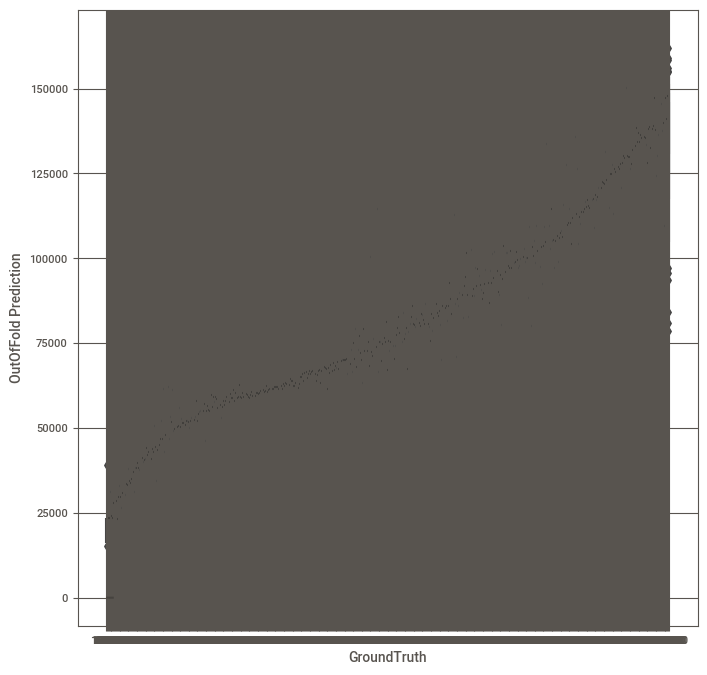

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.boxenplot(data=pd.DataFrame({ "GroundTruth": y, "OutOfFold Prediction": oof }), 
              x="GroundTruth", y="OutOfFold Prediction", ax=ax)

ax.grid()
ax.plot([0, 9], [1, 10], "--", c="black", alpha=.2)

In [ ]:
def visualize_importance(models, train_feat_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_
        _df["column"] = train_feat_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby("column")\
        .sum()[["feature_importance"]]\
        .sort_values("feature_importance", ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x="feature_importance", 
                  y="column", 
                  order=order, 
                  ax=ax, 
                  palette="viridis", 
                  orient="h")
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax

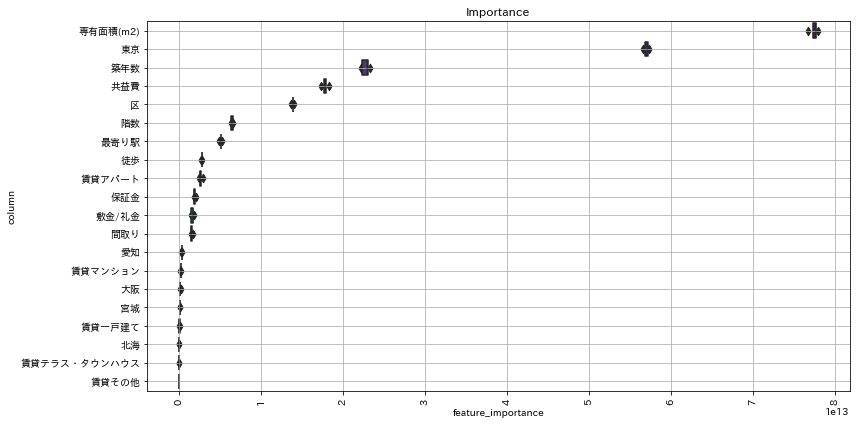

In [ ]:
fig, ax = visualize_importance(models, train_feat_df)

In [ ]:
test_feat_df

,共益費,敷金/礼金,保証金,専有面積(m2),賃貸アパート,賃貸マンション,賃貸一戸建て,賃貸テラス・タウンハウス,賃貸その他,階数,築年数,東京,大阪,愛知,宮城,北海,最寄り駅,徒歩,間取り,区
0,5000,0.0,1.0,49.21,1,0,0,0,0,3,10,0,0,1,0,0,867,3,3,7
1,8000,1.0,0.0,25.10,0,1,0,0,0,11,3,1,0,0,0,0,1350,3,1,15
2,4000,1.0,1.0,18.00,0,1,0,0,0,3,40,1,0,0,0,0,841,4,41,13
3,0,1.0,0.0,37.00,0,1,0,0,0,4,55,1,0,0,0,0,577,1,3,15
4,7000,0.0,1.0,43.98,0,1,0,0,0,5,16,0,0,0,1,0,815,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43744,3000,1.0,1.0,25.00,0,1,0,0,0,8,21,1,0,0,0,0,1353,3,2,10
43745,0,1.0,0.0,34.00,0,1,0,0,0,5,45,1,0,0,0,0,1292,20,3,10
43746,0,1.0,1.0,21.56,0,1,0,0,0,13,19,1,0,0,0,0,481,5,2,8
43747,7000,1.0,1.0,27.58,0,1,0,0,0,7,24,1,0,0,0,0,1132,4,2,0


In [ ]:
# k 個のモデルの予測を作成. shape = (5, N_test,).
pred = np.array([model.predict(test_feat_df.values) for model in models])

# k 個のモデルの予測値の平均 shape = (N_test,).
pred = np.mean(pred, axis=0) 

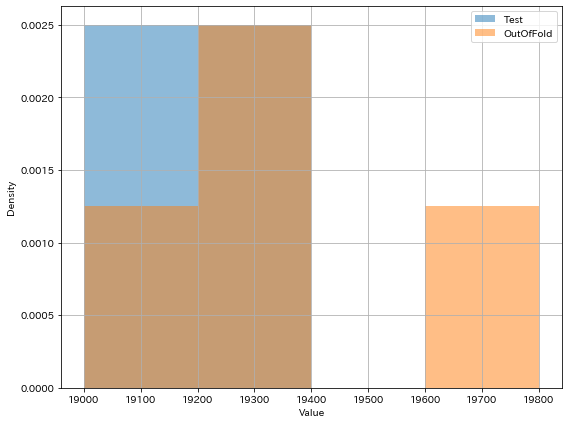

In [ ]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Define the bin range and width
bin_range = (19000, 20000)
bin_width = 200  # Adjust this based on your data and preference

# Create histograms
hist_pred, bins_pred, _ = ax.hist(pred, bins=np.arange(*bin_range, bin_width), density=True, alpha=0.5, label="Test")
hist_oof, bins_oof, _ = ax.hist(oof, bins=np.arange(*bin_range, bin_width), density=True, alpha=0.5, label="OutOfFold")

# Set the y-axis scale (density)
ax.set_ylabel("Density")

# Set the x-axis label
ax.set_xlabel("Value")

# Add a legend
ax.legend()

# Add a grid
ax.grid()

# Set the title if needed
# ax.set_title("Histogram of Predictions")

# Adjust layout
fig.tight_layout()

# Show the plot
plt.show()


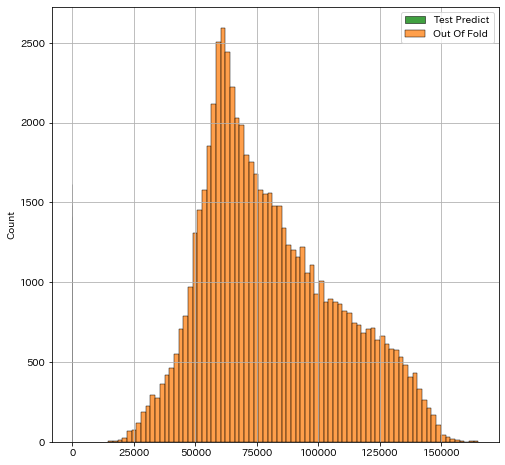

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(np.log1p(pred), label='Test Predict', ax=ax, color='green')
sns.histplot(oof, label='Out Of Fold', ax=ax, color='C1')
ax.legend()
ax.grid()

In [ ]:
# pd.DataFrame({
#     "ID":test_df["ID"],
#     "predict": pred
# }).to_csv(os.path.join("./OUTPUT_DIR", "#13__submission.csv"), index=False)